# Proejct Source Code

Author: Weijun Huang SID: 1008696591

Author: Zhiyuan Lyu SID: 1009239806

Author: Zixuan Wan SID: 1005016199

# Procedure
Hypothesis 1: The test set may not cover all 25 gestures and may be unbalanced, so the performance results might be inaccurate.

Hypothesis 2: The training set may not cover all 25 gestures and may be unbalanced, which performs well in some classes and not so well in others

Methodology Design:
1. Preparation
    - Prerequisite setup:
        - Conda Environment setup
        - CUDA setup
        - Git clone mmpose file
2. File Structure
    - Create file 'model' under the 'mmpose' root path, then put the downloaded model into it.
    - Download FreiHAND data set, extract and rearrange files as mmpose official site shown.
    - Create file 'selecting_1', 'selecting_2', 'selecting_3' under 'mmpose/data/freihand'.
    - Create file 'project_test_data/own_test' under 'mmpose/data/freihand'.
    - Create file 'own_resize_test' under 'mmpose/data/freihand/training'.
    - Create file 'class_own_test' under 'mmpose/data/freihand/training'.
        - under 'class_own_test', create 'c0' to 'c24' files
3. Configure new test set for verifying Hypothesis 1: Freihand + own_test
    - Based on 25 gesture classes, 500 images are selected from Freihand test set (gesture classes are evenly distributed), and corresponding annotations are copied from original freihand_test.json (renamed to freihand_test_ori.json) to a new freihand_test.json under 'mmpose/data/freihand/annotations'.
        - Since images (images number: 130240) under 'mmpose/data/freihand/training/rgb' are training (80%) + test (10%) + validation set (10%), mmpose separate sets by json. And since 3-member group, we need to separate and copy the test images to another 3 files for selecting.
        - So we typically read the key "file_name" from original freihand test Json file (now named 'freihand_test_ori.json') under 'mmpose/data/freihand/annotations' to locate all the test set images then copy to 3 new files 'selecting_1', 'selecting_2' and 'selecting_3' evenly under 'mmpose/data/freihand'
        - Then based on 25 gesture classes
            - member 1 select 167 imagses from selecting_1, 6-7 images for each gesture classes
            - member 2 select 167 imagses from selecting_2, 6-7 images for each gesture classes
            - member 3 select 166 imagses from selecting_3, 6-7 images for each gesture classes
        - Each member returns a txt file containing the selected image names, and the image names in the txt file are displayed line by line
        - The 3 txt files, which named 'selected_imgs_name_1', 'selected_imgs_name_2', 'selected_imgs_name_3', are saved under 'mmpose/data/freihand/annotations'
        - According to the images name in 3 txt files, extract corresponding annotations from original freihand_test.json (renamed to freihand_test_ori.json) to a new freihand_test.json under 'mmpose/data/freihand/annotations'.
    - Construct a dictionary based on original freihand test Json file
        - Read the 500 selected images and extract the corresponding values of key 'images' and 'annotations' from freihand_test_ori.json.
        - Write 500 selected images json to new freihand_test.json (with annotations of selected 500 images) under 'mmpose/data/freihand/annotations'
    - Test on 500 Freihand test set (baseline for Hypothesis 1)
        - Performance Metric:
            - AUC
            - EPE
            - PCK@0.2
    - Collect 50 more images from other sources (provided by Zhiyuan Lyu) for constructing the own images test set, images are stored into 'mmpose/data/freihand/project_test_data/own_test', 2 images for each class
    - Resize the 50 own image test set to $244 \times 244$, then store the resized images into 'mmpose/data/freihand/training/own_resize_test'.
    - Use Labelme to manually annotate 21 keypoints for each resized image. Each images produce one annoations file, so the 50 annoation json files are stored under 'mmpose/data/freihand/training/own_resize_test'.
    - Reconstruct the JSON dictionary structure of own resized image test set according to the outputted Labelme annotation JSON file
    - Append the reconstructed own image JSON data to the new freihand_test.json under 'mmpose/data/freihand/annotations'.
4. Testing for Hypothesis 1 (500 Freihand + 50 own_test)
    - Performance Metric:
        - AUC
        - EPE
        - PCK@0.2
5. Testing (performance of each class) Hypothesis 2
    - Based on 'selected_imgs_name_2', select 5 images for each class
    - Store the image names for each class in 25 individual txt files under 'mmpose/data/freihand/annotations'
    - Copy the 50 own test image annotation JSON files to 'mmpose/data/freihand/training/class_own_test/c*' (* refer to class number, so for class 0, 2 Json File are stored under 'mmpose/data/freihand/training/class_own_test/c0')
    - Testing (performance of each class) Hypothesis 2
        - For each class:
            - step 1: Delete the previous freihand_test.json file before testing for each class
            - step 2: Write the 5 selected Freihand images annoation into freihand_test.json
            - step 3: Test on the 5 selected Freihand images (baseline for Hypothesis 2)
                - Performance Metric:
                    - AUC
                    - EPE
            - step 4: Add the 2 own_test_image annoations into freihand_test.json 
            - step 5: Test on the 5 selected Freihand images + 2 own_test images
                - Performance Metric:
                    - AUC
                    - EPE
6. Results dataframe construction (hypothesis 1 and 2)
    - dataframe for baseline and hypothesis 1
    - dataframe for baseline and hypothesis 2

# 1.Preparation

#### 1.1 Prerequisite Setup
- Environment Setyup
    - Conda Environment Setup
        - conda create -n openmmlab python=3.7 -y
        - conda activate openmmlab
    - CUDA Download
        - cuda 11.6
    - Conda Environment Configuration 1
        - conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.6 -c pytorch -c
conda-forge
        - pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.12.0/index.html
    - Github Public Key Setup
    - Clone git mmpose
        - git clone git@github.com:open-mmlab/mmpose.git
    - Conda Environment Configuration 2
        - pip3 install -e .

#### 1.2 Envirnoment and Import Package

In [2]:
import os
import sys
import pynvml
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import json
import shutil

from mmpose.apis import (inference_top_down_pose_model, init_pose_model, vis_pose_result)
from mmpose.datasets import DatasetInfo
from mmcv.ops import get_compiling_cuda_version

import warnings
warnings.simplefilter("ignore")

# assign gpu
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
# check gpu
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
print(pynvml.nvmlDeviceGetName(handle))
pynvml.nvmlShutdown()
# Check mmcv installation
print('cuda version:', get_compiling_cuda_version())
print()

# check python in conda environment
print(sys.executable)
# check current path
print(os.path.abspath('.'))

e:\Anaconda\envs\openmmlab\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


b'NVIDIA GeForce RTX 3070'
cuda version: 11.3

e:\Anaconda\envs\openmmlab\python.exe
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


# 2.Modified Project File Structure
- Project
    - mmpose
        - data <span style="color:red">-> img root and json file </span>
            - <span style="color:blue">freihand</span>
                - <span style="color:blue">annotations</span>
                    - <span style="color:blue">freihand_test.json</span>
                    - <span style="color:blue">freihand_test_ori.json</span>
                    - <span style="color:blue">selected_imgs_name_1.txt</span> <span style="color:red">-> selected freihand test set images for member 1</span>
                    - <span style="color:blue">selected_imgs_name_2.txt</span> <span style="color:red">-> selected freihand test set images for member 2</span>
                    - <span style="color:blue">selected_imgs_name_3.txt</span> <span style="color:red">-> selected freihand test set images for member 3</span>
                    - <span style="color:blue">c*_imgs_name.txt</span> <span style="color:red">-> 5 selected freihand test images name for class *</span>
                - <span style="color:blue">project_test_data</span>
                    - <span style="color:blue">own_test</span> <span style="color:red">-> own test set with images  (original, unresized)</span>
                - <span style="color:blue">selecting_1</span> <span style="color:red">-> original freihand test set images for member 1</span>
                - <span style="color:blue">selecting_2</span> <span style="color:red">-> original freihand test set images for member 2</span>
                - <span style="color:blue">selecting_3</span> <span style="color:red">-> original freihand test set images for member 3</span>
                - <span style="color:blue">training</span>
                    - <span style="color:blue">class_own_test</span> <span style="color:red">-> labelme annotation files for each class</span>
                        - <span style="color:blue">c0</span> <span style="color:red">-> labelme annotation files for class 0</span>
                        - <span style="color:blue">...</span>
                    - <span style="color:blue">own_resize_test</span> <span style="color:red">-> resized own test set and labelme annotation files</span>
                    - <span style="color:blue">rgb</span> <span style="color:red">-> all original data (training + test + validation, it separate sets by using json)</span>
        - <span style="color:blue">model</span>
            - <span style="color:blue">res50_freihand_224x224-ff0799bc_20200914.pth</span> <span style="color:red">-> trained model</span>

# 3.Configure New Test Set: FreiHand + own_test

#### 3.1 Select 500 Images from FreiHand Test Set based on 25 classes  (gesture classes are evenly distributed)

Based on 25 gesture classes shown below, 500 images are selected from Freihand test set (gesture classes are evenly distributed), and corresponding annotations are copied from original freihand_test.json (renamed to freihand_test_ori.json) to a new freihand_test.json under 'mmpose/data/freihand/annotations'.

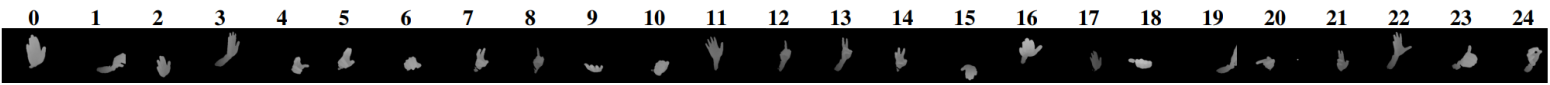

- Since images (130240) under 'mmpose/data/freihand/training/rgb' are training (80%) + test (10%) + validation set (10%), mmpose separate sets by using json. And since 3-member group, we need to separate and copy the test images to another 3 files for selecting.
- So we typically read the key "file_name" from original freihand test Json file (now named 'freihand_test_ori.json') under 'mmpose/data/freihand/annotations' to locate all the test set images then copy to 3 new files 'selecting_1', 'selecting_2' and 'selecting_3' under 'mmpose/data/freihand'

In [2]:
freihand_ori_test_json_path = 'mmpose/data/freihand/annotations/freihand_test_ori.json'
with open(freihand_ori_test_json_path, 'r', encoding='utf-8') as f_ori: # open freihand_test_ori.json
    ori_freihand_test_json = json.load(f_ori) # load json data from freihand_test_ori.json

In [3]:
img_root_path = 'mmpose/data/freihand/'
# Divide the copied images into 3 groups since 3 members for the project
save_ori_test_path_1 = 'mmpose/data/freihand/selecting_1/'
save_ori_test_path_2 = 'mmpose/data/freihand/selecting_2/'
save_ori_test_path_3 = 'mmpose/data/freihand/selecting_3/'
# copy ori test imgs to 3 files
count = 0
for i in range(len(ori_freihand_test_json['images'])):
    ori_freihand_test_img_path = img_root_path + ori_freihand_test_json['images'][i]['file_name']
    if count < 4341:
        save_ori_test_img = save_ori_test_path_1 + ori_freihand_test_img_path.split('rgb/')[1]
    elif count < 8682:
        save_ori_test_img = save_ori_test_path_2 + ori_freihand_test_img_path.split('rgb/')[1]
    else:
        save_ori_test_img = save_ori_test_path_3 + ori_freihand_test_img_path.split('rgb/')[1]
    shutil.copy(ori_freihand_test_img_path, save_ori_test_img)
    count +=1
print(count)

13024


- Then based on 25 gesture classes
    - member 1 select 167 imagses from selecting_1, 6-7 images for each gesture classes
    - member 2 select 167 imagses from selecting_2, 6-7 images for each gesture classes
    - member 3 select 166 imagses from selecting_3, 6-7 images for each gesture classes
- Each member returns a txt file containing the selected image name, and the image names in the txt file are displayed line by line
- The 3 txt files, which named 'selected_imgs_name_1', 'selected_imgs_name_2', 'selected_imgs_name_3', are saved under 'mmpose\data\freihand\annotations'
- According to the images name in 3 txt files, extract corresponding annotations from original freihand_test.json (renamed to freihand_test_ori.json) to a new freihand_test.json under 'mmpose/data/freihand/annotations'.

In [4]:
print(ori_freihand_test_json.keys()) # check keys in original freihand test dictionary

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


- ori_freihand_test_json is loaded from freihand_test_ori.json, it is a large dictionary which has 5 keys ['info', 'licenses', 'images', 'annotations', 'categories']
- values of 'images' key is a list containing 13024 dictionaries, each dict has 4 keys: ['file_name', 'height', 'width' and 'id']

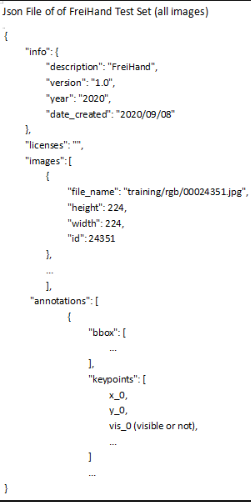

- Construct a dictionary based on above structure

In [5]:
# new freihand_test.json
# construct the dict of freihand_test as original one, but the 'images' and 'annotations' are empty for now
freihand_new_test = {}
freihand_new_test['info'] = ori_freihand_test_json['info'] # this is fixed
freihand_new_test['licenses'] = ori_freihand_test_json['licenses'] # this is fixed
freihand_new_test['images'] = [] # need to append from ori annoataion according to selected 123
freihand_new_test['annotations'] = [] # need to append from ori annoataion according to selected 123
freihand_new_test['categories'] = ori_freihand_test_json['categories'] # this is fixed

- Read the 500 selected images and extract the corresponding 'images' values and 'annotations' values from freihand_test_ori.json 

In [6]:
# selected_1
selected_imgs_name_1_txt = 'mmpose/data/freihand/annotations/selected_imgs_name_1.txt'
with open(selected_imgs_name_1_txt, 'r') as selected_1: # read txt file
        lines = selected_1.readlines() # read line by line and store in list
        for line in lines: # for every element (every line in txt)
            line = line.strip('\n') # remove \n
            for i in range(len(ori_freihand_test_json['images'])): # compare the image name to image name in original test json
                if line == ori_freihand_test_json['images'][i]['file_name'].split('rgb/')[1]: # if images name matches
                    freihand_new_test['images'].append(ori_freihand_test_json['images'][i]) # append that images list element into new dict  
                    freihand_new_test['annotations'].append(ori_freihand_test_json['annotations'][i]) # append that annotations list element into new dict  
# selected_2
selected_imgs_name_2_txt = 'mmpose/data/freihand/annotations/selected_imgs_name_2.txt'
with open(selected_imgs_name_2_txt, 'r') as selected_2:
        lines = selected_2.readlines()
        for line in lines:
            line = line.strip('\n')
            for i in range(len(ori_freihand_test_json['images'])):
                if line == ori_freihand_test_json['images'][i]['file_name'].split('rgb/')[1]:
                    freihand_new_test['images'].append(ori_freihand_test_json['images'][i])
                    freihand_new_test['annotations'].append(ori_freihand_test_json['annotations'][i])
# selected_3
selected_imgs_name_3_txt = 'mmpose/data/freihand/annotations/selected_imgs_name_3.txt'
with open(selected_imgs_name_3_txt, 'r') as selected_3:
        lines = selected_3.readlines()
        for line in lines:
            line = line.strip('\n')
            for i in range(len(ori_freihand_test_json['images'])):
                if line == ori_freihand_test_json['images'][i]['file_name'].split('rgb/')[1]:
                    freihand_new_test['images'].append(ori_freihand_test_json['images'][i])
                    freihand_new_test['annotations'].append(ori_freihand_test_json['annotations'][i])

- Write 500 selected images json to new freihand_test.json under 'mmpose/data/freihand/annotations'

In [7]:
freihand_test_json_path_tmp = 'mmpose/data/freihand/annotations/freihand_test.json'
with open(freihand_test_json_path_tmp, 'w', encoding='utf-8') as f_new:
    f_new.write(json.dumps(freihand_new_test, indent=4, ensure_ascii=False)) # write json file

#### 3.2 Test on 500 Freihand test set (baseline for Hypothesis 1)

- AUC

In [8]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/500, elapsed: 0s, ETA:
[                                 ] 1/500, 0.1 task/s, elapsed: 9s, ETA:  4472s
[                                 ] 2/500, 0.2 task/s, elapsed: 9s, ETA:  2232s
[                                 ] 3/500, 0.3 task/s, elapsed: 9s, ETA:  1485s
[                                 ] 4/500, 0.4 task/s, elapsed: 9s, ETA:  1111s
[                                 ] 5/500, 0.6 task/s, elapsed: 9s, ETA:   887s
[                                 ] 6/500, 0.7 task/s, elapsed: 9s, ETA:   738s
[                                 ] 7/500, 0.8 task/s, elapsed: 9s, ETA:   631s
[                                 

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [9]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/500, elapsed: 0s, ETA:
[                                 ] 1/500, 0.1 task/s, elapsed: 9s, ETA:  4613s
[                                 ] 2/500, 0.2 task/s, elapsed: 9s, ETA:  2302s
[                                 ] 3/500, 0.3 task/s, elapsed: 9s, ETA:  1531s
[                                 ] 4/500, 0.4 task/s, elapsed: 9s, ETA:  1146s
[                                 ] 5/500, 0.5 task/s, elapsed: 9s, ETA:   915s
[                                 ] 6/500, 0.6 task/s, elapsed: 9s, ETA:   761s
[                                 ] 7/500, 0.8 task/s, elapsed: 9s, ETA:   651s
[                                 

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- PCK

In [10]:
# test model on Test set (PCK)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval PCK

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/500, elapsed: 0s, ETA:
[                                 ] 1/500, 0.1 task/s, elapsed: 9s, ETA:  4545s
[                                 ] 2/500, 0.2 task/s, elapsed: 9s, ETA:  2268s
[                                 ] 3/500, 0.3 task/s, elapsed: 9s, ETA:  1509s
[                                 ] 4/500, 0.4 task/s, elapsed: 9s, ETA:  1129s
[                                 ] 5/500, 0.5 task/s, elapsed: 9s, ETA:   902s
[                                 ] 6/500, 0.7 task/s, elapsed: 9s, ETA:   750s
[                                 ] 7/500, 0.8 task/s, elapsed: 9s, ETA:   642s
[                                 

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


#### 3.3 Collect 50 Images from other sources (provided by Zhiyuan Lyu)

- Take a look at original own_test images
    - own original images are saved in 'mmpose/data/freihand/project_test_data/own_test'

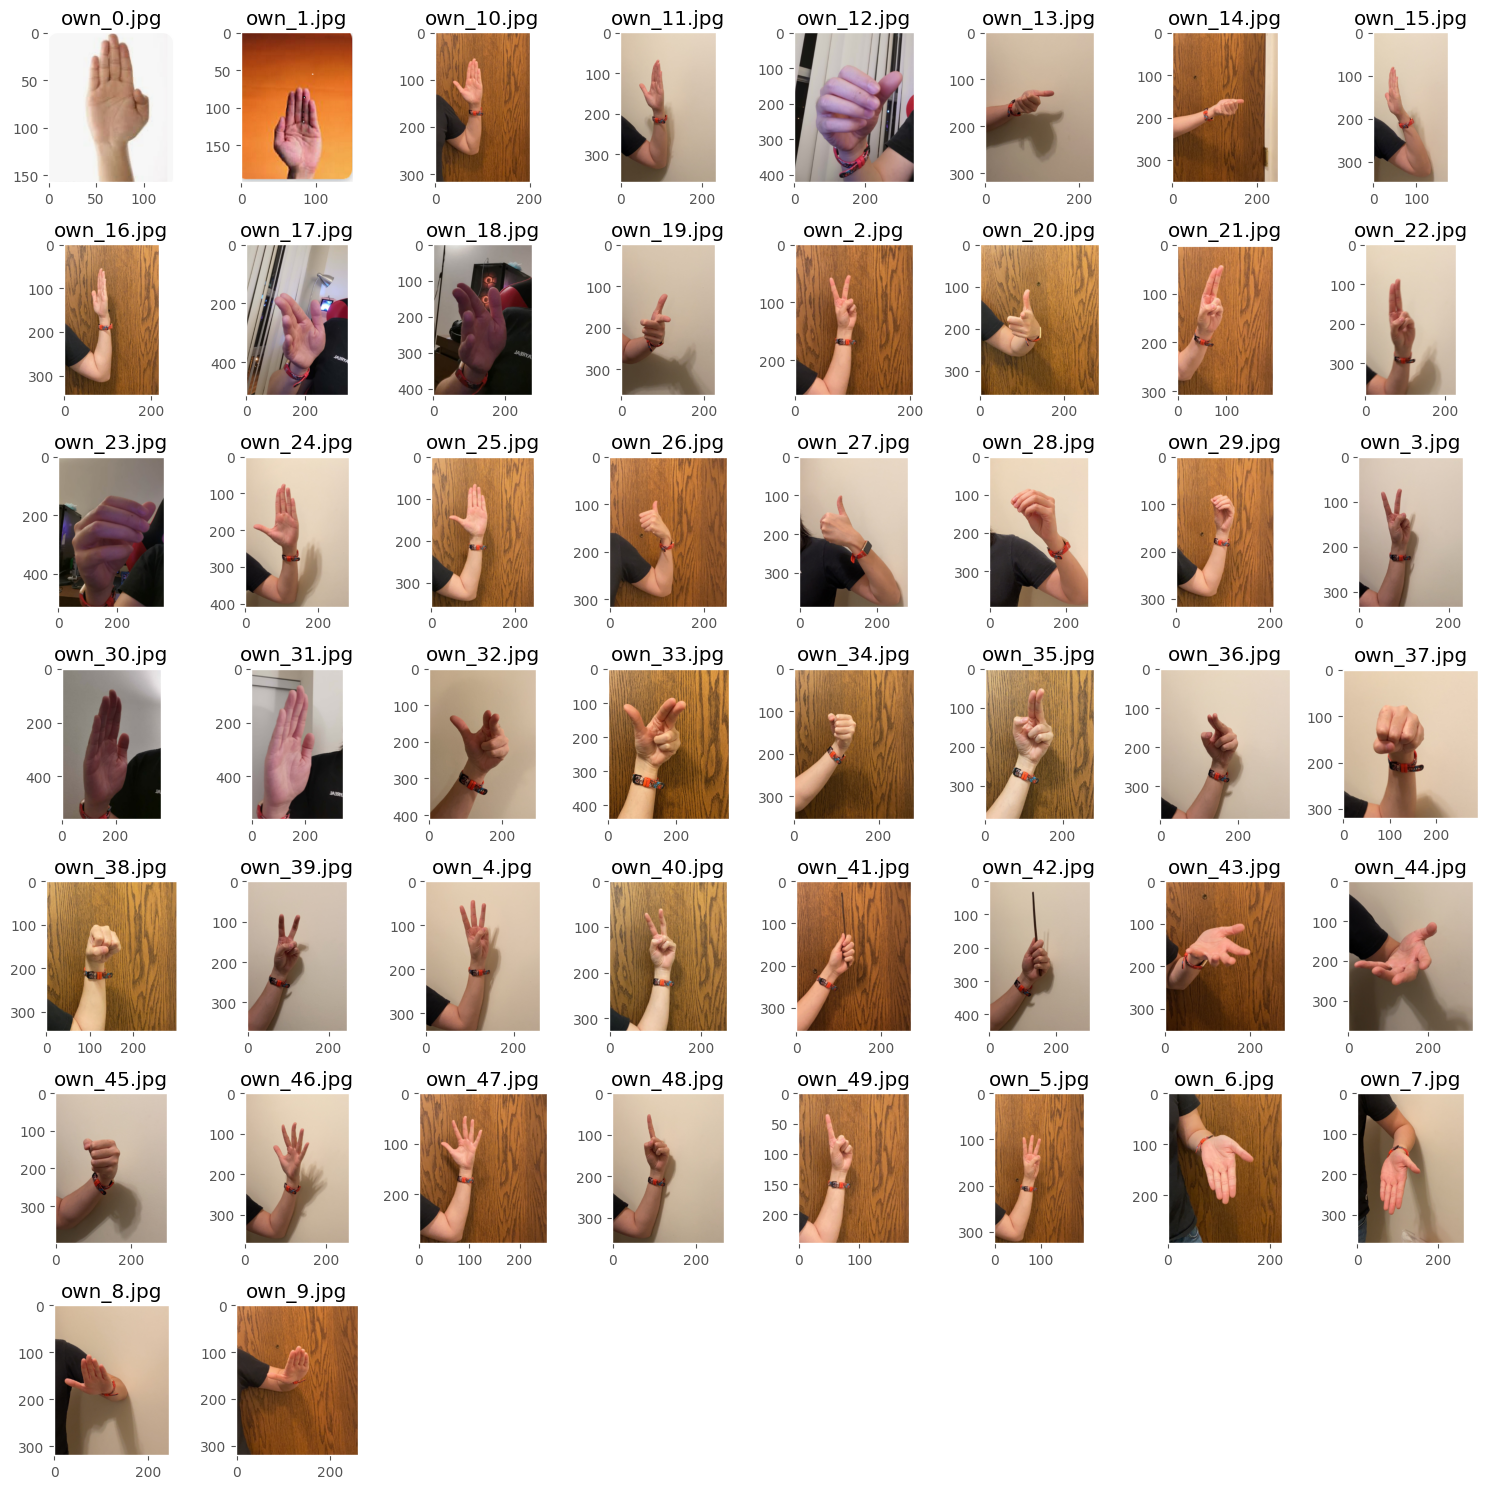

In [257]:
own_test = 'mmpose/data/freihand/project_test_data/own_test' # own images path (original), this path will only contain own ori img file
own_image_list = os.listdir(own_test) # list contains file name under img path

# plot original own_test img
plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(7, 8)
for i in range(len(own_image_list)):
    ax = plt.subplot(gs[i])
    own_image_path = own_test + '/' + own_image_list[i] # concat path and image name
    own_img = cv2.imread(own_image_path) # read img by the concated path
    plot_own_img = own_img[:, :, ::-1]  # cv2 read image as BGR so need to transfer it to RGB if using plt.imshow()
    ax.set_title(own_image_list[i])
    ax.grid(False)
    ax.imshow(plot_own_img)
plt.tight_layout()
plt.show()

#### 3.4 Resize the 50 own images test set to $244 \times 244$ and Store the resized images into 'mmpose/data/freihand/training/own_resize_test'

- Resize own images to 224x244, since model input is 224x224
    - resized images are saved in 'mmpose/data/freihand/training/own_resize_test'

In [12]:
own_resize_test = 'mmpose/data/freihand/training/own_resize_test/' # own images path (resized), this path will contain own resized img file and json file
for i in range(len(own_image_list)):
    own_image_path = own_test + '/' + own_image_list[i]
    own_img = cv2.imread(own_image_path)
    if own_img.shape != '(224, 224, 3)': # check size
        img_resize = cv2.resize(own_img, dsize=(224, 224)) # resize
        own_resize_test_path = own_resize_test + own_image_list[i]
        cv2.imwrite(own_resize_test_path, img_resize) # put in own_resize_test

- Take a look at resized images in own_resize_test

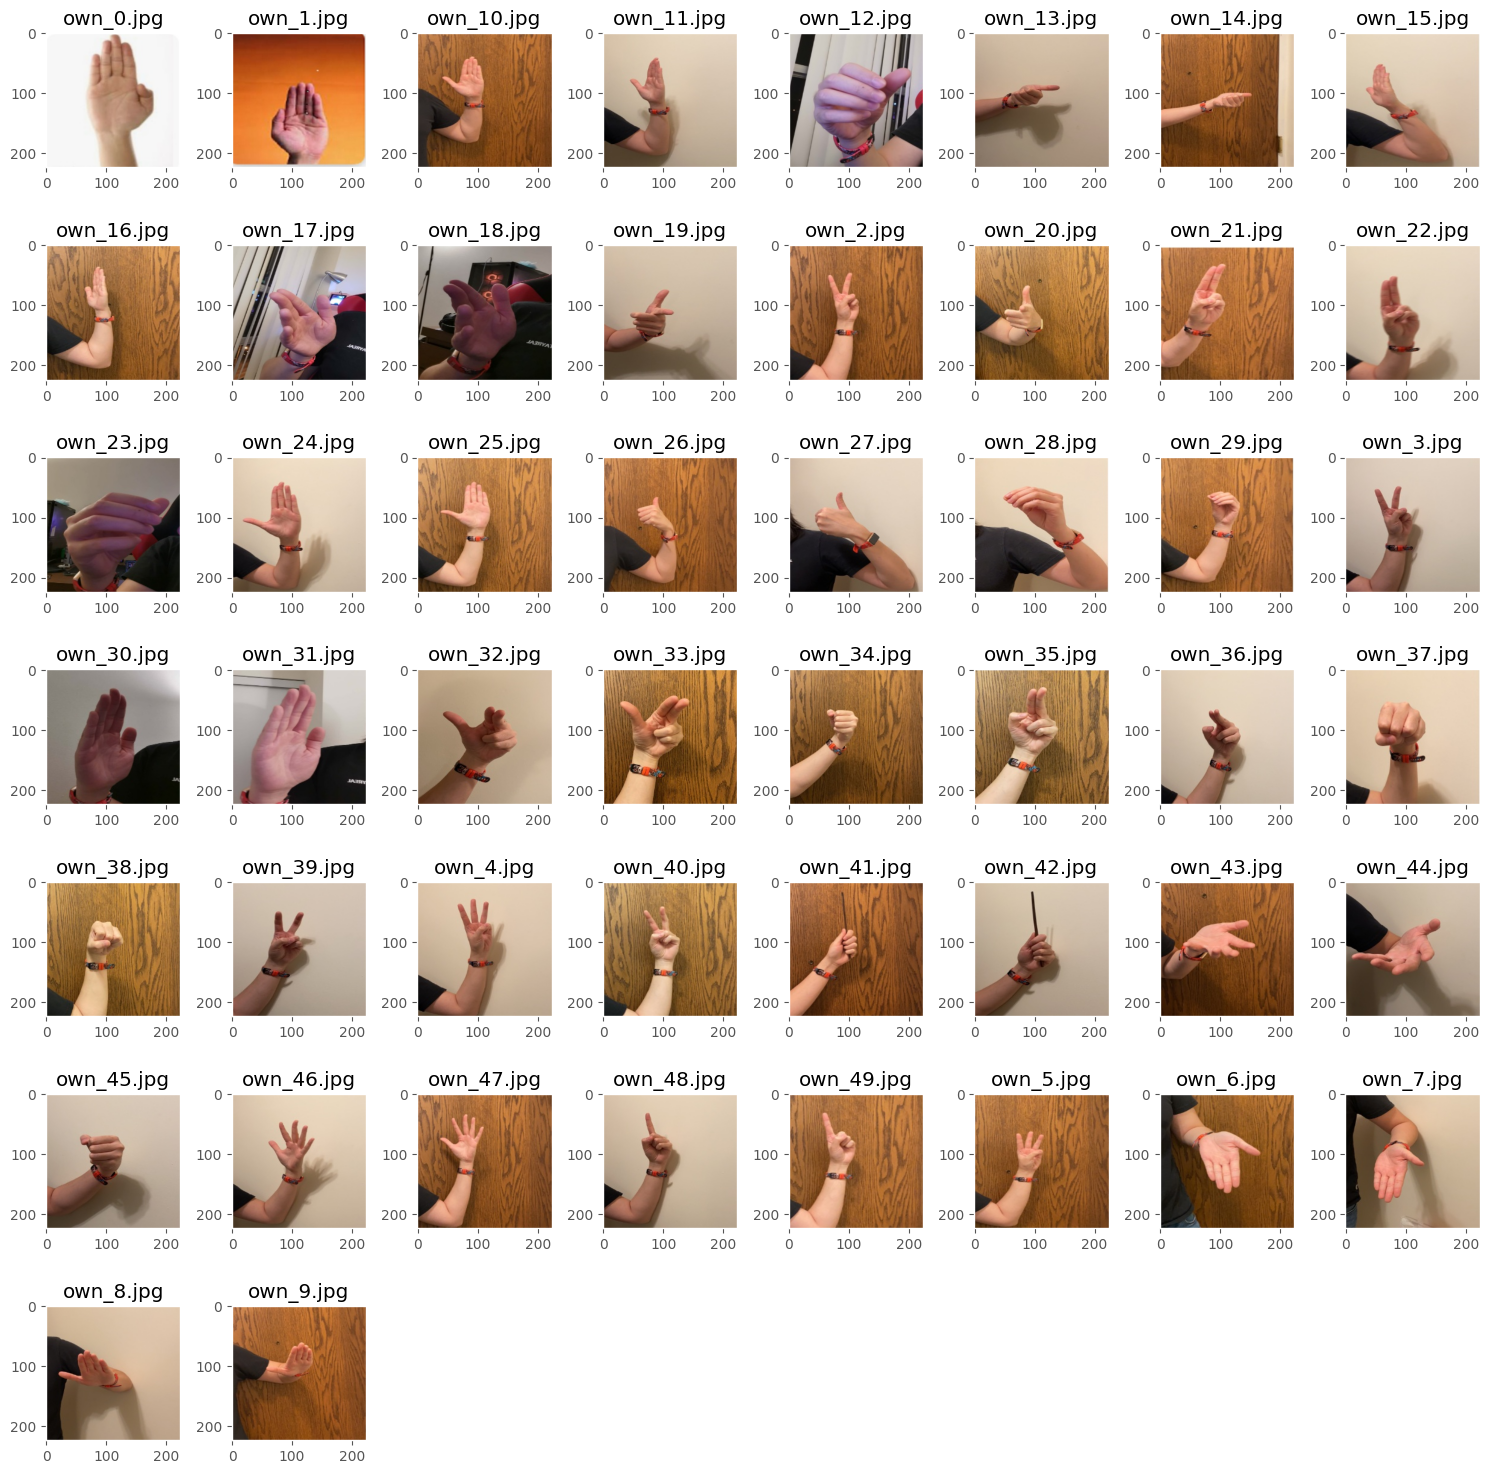

In [259]:
# plot resize own_test imgs
plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(7, 8)
for i in range(len(own_image_list)):
    ax = plt.subplot(gs[i])
    own_resized_image_path = own_resize_test + '/' + own_image_list[i] # concat path and image name
    own_resized_img = cv2.imread(own_resized_image_path) # read img by the concated path
    plot_own_resized_img = own_resized_img[:, :, ::-1]  # cv2 read image as BGR so need to transfer it to RGB if using plt.imshow()
    ax.set_title(own_image_list[i])
    ax.grid(False)
    ax.imshow(plot_own_resized_img)
plt.tight_layout()
plt.show()

#### 3.5 Use Labelme to manually annotate 21 keypoints for each resized image

- Use Labelme to annotate 50 images of own images set under 'mmpose/data/freihand/training/own_resize_test', each images contains 21 points
- Annotation method: 
    - Edit -> Create Point -> click the corresponding location in figure
    - Input annotation number (0 for wrist...). And in 'group', input 0 if invisible, 1 if visible

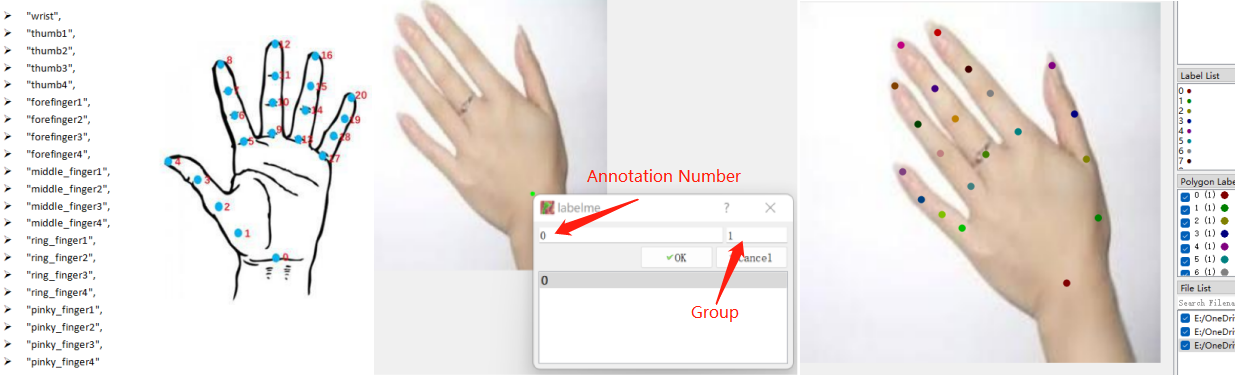

- Then the 50 annotated Json files are automatically saved under 'mmpose/data/freihand/training/own_resize_test'

#### 3.6 Reconstruct the Json dictionary structure of own resized image test set according to the outputted labelme annotation json file

- Need to combines the 50 Labelme annotation Json files with FreiHand Test Set Json file
- But first we need to reconstruct the dictionary for Labelme annotation Json file as dictionary of FreiHand Test Set Json file
- Json format:

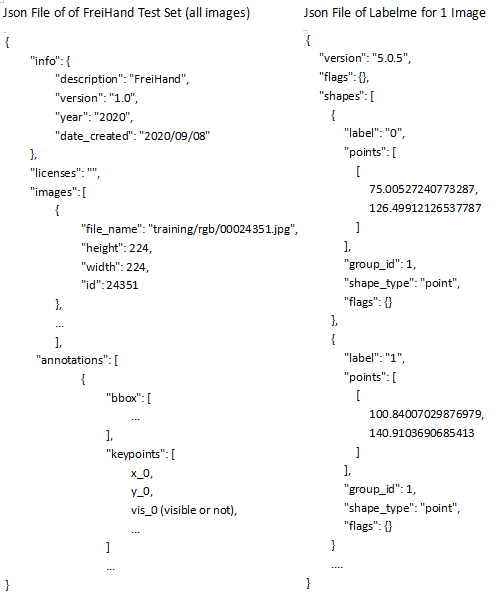

- Extract annotations Json data from Labelme annotation
- Transfer into FreiHand Test Set form

In [14]:
labelme_json_path = 'mmpose/data/freihand/training/own_resize_test' # own images path (resized), this path will contain own resized img file and json file
labelme_json_list = os.listdir(labelme_json_path) # list contains file name under img path

labelme_images_list = [] # list to store images properties (images key of freidhand test set json)
labelme_annotations_list = [] # list to store annotations (annotations key of freidhand test set json)

for i in range(len(labelme_json_list)):
    if labelme_json_list[i].split('.')[1] == 'json': # file name only end with json
        labelme_json_file_path = labelme_json_path + '/' + labelme_json_list[i] # labelme json whole path

        with open(labelme_json_file_path, 'r', encoding='utf-8') as f1: # open labelme json
            labelme_json = json.load(f1) # load json data from open labelme json
            
            labelme_images = { # reconstruct the dictionary for images key
                "file_name": 'training/own_resize_test/' + labelme_json['imagePath'],
                "height": labelme_json['imageHeight'],
                "width": labelme_json['imageWidth'],
                "id": int(labelme_json['imagePath'].split('_')[1].split('.')[0])
            }
            labelme_images_list.append(labelme_images) # append for all images, since each labelme json file is 1 image

            keypoints = [] # store 21 keypoints annotations for each image
            for i in range(len(labelme_json['shapes'])):
                keypoints.append(labelme_json['shapes'][i]['points'][0][0]) # x
                keypoints.append(labelme_json['shapes'][i]['points'][0][1]) # y
                keypoints.append(labelme_json['shapes'][i]['group_id']) # visible or not
                
            labelme_annotations = { # reconstruct the dictionary for annotations key
                "bbox": [0, 0, 224, 224], # bounding box, use entire image as bbox
                "keypoints": keypoints, # the keypoints list above
                "category_id": 1, # it seems not in used, but needed
                "id": int(labelme_json['imagePath'].split('_')[1].split('.')[0]), # image id
                "image_id": int(labelme_json['imagePath'].split('_')[1].split('.')[0]), # image id
                "segmentation": [],
                "iscrowd": 0,
                "area": 59536

            }
            labelme_annotations_list.append(labelme_annotations) # append for all images, since each labelme json file is 1 image

#### 3.7 Combine the new freihand_test.json (500 images) with reconstructed own image json data

- Constrcut the new test set json by constructing the Labelme annotation as test set json file and combine with it

In [15]:
freihand_test_json_path_tmp = 'mmpose/data/freihand/annotations/freihand_test.json' # the new freihand_test.json
with open(freihand_test_json_path_tmp, 'r', encoding='utf-8') as f2: # open new freihand_test.json
    freihand_test_json = json.load(f2) # load json data from freihand_test.json

    for i in range(len(labelme_images_list)): # append 1 image data each iteration, so the list [ ] wont go in
        freihand_test_json['images'].append(labelme_images_list[i]) # images key
        freihand_test_json['annotations'].append(labelme_annotations_list[i]) # annotations key

with open(freihand_test_json_path_tmp, 'w', encoding='utf-8') as f2:
    f2.write(json.dumps(freihand_test_json, indent=4, ensure_ascii=False)) # write json file

# 4.Testing (500 Freihand + 50 own_test) Hypothesis 1

- AUC

In [16]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 548
=> load 550 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/550, elapsed: 0s, ETA:
[                                 ] 1/550, 0.1 task/s, elapsed: 9s, ETA:  5215s
[                                 ] 2/550, 0.2 task/s, elapsed: 9s, ETA:  2603s
[                                 ] 3/550, 0.3 task/s, elapsed: 9s, ETA:  1732s
[                                 ] 4/550, 0.4 task/s, elapsed: 9s, ETA:  1297s
[                                 ] 5/550, 0.5 task/s, elapsed: 9s, ETA:  1035s
[                                 ] 6/550, 0.6 task/s, elapsed: 9s, ETA:   861s
[                                 ] 7/550, 0.7 task/s, elapsed: 9s, ETA:   737s
[                                 

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [17]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 548
=> load 550 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/550, elapsed: 0s, ETA:
[                                ] 1/550, 0.1 task/s, elapsed: 10s, ETA:  5416s
[                                ] 2/550, 0.2 task/s, elapsed: 10s, ETA:  2703s
[                                ] 3/550, 0.3 task/s, elapsed: 10s, ETA:  1799s
[                                ] 4/550, 0.4 task/s, elapsed: 10s, ETA:  1347s
[                                ] 5/550, 0.5 task/s, elapsed: 10s, ETA:  1075s
[                                ] 6/550, 0.6 task/s, elapsed: 10s, ETA:   894s
[                                ] 7/550, 0.7 task/s, elapsed: 10s, ETA:   765s
[                                ]

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- PCK

In [18]:
# test model on Test set (PCK)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval PCK

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 548
=> load 550 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/550, elapsed: 0s, ETA:
[                                ] 1/550, 0.1 task/s, elapsed: 10s, ETA:  5312s
[                                ] 2/550, 0.2 task/s, elapsed: 10s, ETA:  2651s
[                                ] 3/550, 0.3 task/s, elapsed: 10s, ETA:  1764s
[                                ] 4/550, 0.4 task/s, elapsed: 10s, ETA:  1321s
[                                ] 5/550, 0.5 task/s, elapsed: 10s, ETA:  1055s
[                                ] 6/550, 0.6 task/s, elapsed: 10s, ETA:   877s
[                                ] 7/550, 0.7 task/s, elapsed: 10s, ETA:   751s
[                                ]

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


# 5.Testing (performance of each class) Hypothesis 2

- Based on 'selected_imgs_name_2', select 5 images for each class
- Store the image names for each class in 25 individual txt files udner 'mmpose/data/freihand/annotations'
- Copy the 50 own test image annotation JSON files to 'mmpose/data/freihand/training/class_own_test/c*' (* refer to class number, so for class 0, 2 Json File are stored under 'mmpose/data/freihand/training/class_own_test/c0')

- Function to delete freihand_test.json

In [19]:
def remove_test_json():
    os.remove("mmpose/data/freihand/annotations/freihand_test.json")

- Function to write json for each class

In [20]:
def write_json_class(class_img_name_txt):
    freihand_ori_test_json_path = 'mmpose/data/freihand/annotations/freihand_test_ori.json'
    with open(freihand_ori_test_json_path, 'r', encoding='utf-8') as f_ori: # open freihand_test_ori.json
        ori_freihand_test_json = json.load(f_ori) # load json data from freihand_test_ori.json

    # new freihand_test.json
    # construct the dict of freihand_test as original one, but the 'images' and 'annotations' are empty for now
    freihand_new_test = {}
    freihand_new_test['info'] = ori_freihand_test_json['info'] # this is fixed
    freihand_new_test['licenses'] = ori_freihand_test_json['licenses'] # this is fixed
    freihand_new_test['images'] = [] # need to append from ori annoataion according to selected 123
    freihand_new_test['annotations'] = [] # need to append from ori annoataion according to selected 123
    freihand_new_test['categories'] = ori_freihand_test_json['categories'] # this is fixed

    # selected_1
    selected_imgs_name_1_txt = 'mmpose/data/freihand/annotations/' + class_img_name_txt
    with open(selected_imgs_name_1_txt, 'r') as selected_1: # read txt file
            lines = selected_1.readlines() # read line by line and store in list
            for line in lines: # for every element (every line in txt)
                line = line.strip('\n') # remove \n
                for i in range(len(ori_freihand_test_json['images'])): # compare the image name to image name in original test json
                    if line == ori_freihand_test_json['images'][i]['file_name'].split('rgb/')[1]: # if images name matches
                        freihand_new_test['images'].append(ori_freihand_test_json['images'][i]) # append that images list element into new dict  
                        freihand_new_test['annotations'].append(ori_freihand_test_json['annotations'][i]) # append that annotations list element into new dict  

    freihand_test_json_path_tmp = 'mmpose/data/freihand/annotations/freihand_test.json'
    with open(freihand_test_json_path_tmp, 'w', encoding='utf-8') as f_new:
        f_new.write(json.dumps(freihand_new_test, indent=4, ensure_ascii=False)) # write json file

- Function to add class own images to json

In [21]:
def add_class_2_json(class_file):
    labelme_json_path = 'mmpose/data/freihand/training/class_own_test/'+ class_file # own images path (resized), this path will contain own resized img file and json file
    labelme_json_list = os.listdir(labelme_json_path) # list contains file name under img path

    labelme_images_list = [] # list to store images properties (images key of freidhand test set json)
    labelme_annotations_list = [] # list to store annotations (annotations key of freidhand test set json)

    for i in range(len(labelme_json_list)):
        if labelme_json_list[i].split('.')[1] == 'json': # file name only end with json
            labelme_json_file_path = labelme_json_path + '/' + labelme_json_list[i] # labelme json whole path

            with open(labelme_json_file_path, 'r', encoding='utf-8') as f1: # open labelme json
                labelme_json = json.load(f1) # load json data from open labelme json
                
                labelme_images = { # reconstruct the dictionary for images key
                    "file_name": 'training/own_resize_test/' + labelme_json['imagePath'],
                    "height": labelme_json['imageHeight'],
                    "width": labelme_json['imageWidth'],
                    "id": int(labelme_json['imagePath'].split('_')[1].split('.')[0])
                }
                labelme_images_list.append(labelme_images) # append for all images, since each labelme json file is 1 image

                keypoints = [] # store 21 keypoints annotations for each image
                for i in range(len(labelme_json['shapes'])):
                    keypoints.append(labelme_json['shapes'][i]['points'][0][0]) # x
                    keypoints.append(labelme_json['shapes'][i]['points'][0][1]) # y
                    keypoints.append(labelme_json['shapes'][i]['group_id']) # visible or not
                    
                labelme_annotations = { # reconstruct the dictionary for annotations key
                    "bbox": [0, 0, 224, 224], # bounding box, use entire image as bbox
                    "keypoints": keypoints, # the keypoints list above
                    "category_id": 1, # it seems not in used, but needed
                    "id": int(labelme_json['imagePath'].split('_')[1].split('.')[0]), # image id
                    "image_id": int(labelme_json['imagePath'].split('_')[1].split('.')[0]), # image id
                    "segmentation": [],
                    "iscrowd": 0,
                    "area": 59536

                }
                labelme_annotations_list.append(labelme_annotations) # append for all images, since each labelme json file is 1 image
        
    freihand_test_json_path_tmp = 'mmpose/data/freihand/annotations/freihand_test.json' # the new freihand_test.json
    with open(freihand_test_json_path_tmp, 'r', encoding='utf-8') as f2: # open new freihand_test.json
        freihand_test_json = json.load(f2) # load json data from freihand_test.json

        for i in range(len(labelme_images_list)): # append 1 image data each iteration, so the list [ ] wont go in
            freihand_test_json['images'].append(labelme_images_list[i]) # images key
            freihand_test_json['annotations'].append(labelme_annotations_list[i]) # annotations key

    with open(freihand_test_json_path_tmp, 'w', encoding='utf-8') as f2:
        f2.write(json.dumps(freihand_test_json, indent=4, ensure_ascii=False)) # write json file

## 5.1 Class 0

- Write 5 imgs json for class 0

In [22]:
remove_test_json() # delete previous freihand_test.json
write_json_class('c0_imgs_name.txt') # Write the 5 selected Freihand images annoation into freihand_test.json

- Test on 5 class 0 

- AUC

In [23]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.925714285714286
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [24]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 1.5279529389880953
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 0 own images to json

In [25]:
add_class_2_json('c0')

- Test on 5+2 class 0 

- AUC

In [26]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8928571428571432
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [27]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 2.4842375670971513
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.2 Class 1

- Write 5 imgs json for class 1

In [28]:
remove_test_json()
write_json_class('c1_imgs_name.txt')

- Test on 5 class 1

- AUC

In [29]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8142857142857144
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [30]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 4.831201753162202
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 1 own images to json

In [31]:
add_class_2_json('c1')

- Test on 5+2 class 1

- AUC

In [32]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8174149659863946
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [33]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 4.72332763671875
e:\OneDrive - Unive

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.3 Class 2

- Write 5 imgs json for class 2

In [34]:
remove_test_json()
write_json_class('c2_imgs_name.txt')

- Test on 5 class 2


- AUC

In [35]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.9033333333333337
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [36]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.194779023670015
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 2 own images to json

In [37]:
add_class_2_json('c2')

- Test on 5+2 class 2

- AUC

In [38]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.885385487528345
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [39]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 2.76630068496919
e:\OneDrive - Unive

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.4 Class 3

- Write 5 imgs json for class 3

In [40]:
remove_test_json()
write_json_class('c3_imgs_name.txt')

- Test on 5 class 3


- AUC

In [41]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.9314285714285717
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [42]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 1.2103806268601192
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 3 own images to json

In [43]:
add_class_2_json('c3')

- Test on 5+2 class 3

- AUC

In [44]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.9085034013605445
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [45]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 1.9321704267644557
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.5 Class 4

- Write 5 imgs json for class 4

In [46]:
remove_test_json()
write_json_class('c4_imgs_name.txt')

- Test on 5 class 4


- AUC

In [47]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8719047619047622
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [48]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '



Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 3.1050606863839287


- Add class 4 own images to json

In [49]:
add_class_2_json('c4')

- Test on 5+2 class 4

- AUC

In [50]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8683673469387758
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [51]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.1993723759034864
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.6 Class 5

- Write 5 imgs json for class 5

In [52]:
remove_test_json()
write_json_class('c5_imgs_name.txt')

- Test on 5 class 5


- AUC

In [53]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8661904761904765
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [54]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 3.255031040736607
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 5 own images to json

In [55]:
add_class_2_json('c5')

- Test on 5+2 class 5

- AUC

In [56]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8690476190476193
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [57]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.1595566937712585
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.7 Class 6

- Write 5 imgs json for class 6

In [58]:
remove_test_json()
write_json_class('c6_imgs_name.txt')

- Test on 5 class 6


- AUC

In [59]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    36s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.4 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.9033333333333337
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [60]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.194779023670015
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 6 own images to json

In [61]:
add_class_2_json('c6')

- Test on 5+2 class 6

- AUC

In [62]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.4 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.7664399092970521
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [63]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 8.862333668221673
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.8 Class 7

- Write 5 imgs json for class 7

In [64]:
remove_test_json()
write_json_class('c7_imgs_name.txt')

- Test on 5 class 7


- AUC

In [65]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8914285714285717
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [66]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.5343296595982143
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 7 own images to json

In [67]:
add_class_2_json('c7')

- Test on 5+2 class 7

- AUC

In [68]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8648526077097509
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [69]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    54s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.4 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.373360393716277
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.9 Class 8

- Write 5 imgs json for class 8

In [70]:
remove_test_json()
write_json_class('c8_imgs_name.txt')

- Test on 5 class 8


- AUC

In [71]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.7995238095238097
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [72]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 5.2502197265625
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 8 own images to json

In [73]:
add_class_2_json('c8')

- Test on 5+2 class 8

- AUC

In [74]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.7982993197278915
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [75]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 5.302793749335672
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.10 Class 9

- Write 5 imgs json for class 9

In [76]:
remove_test_json()
write_json_class('c9_imgs_name.txt')

- Test on 5 class 9


- AUC

In [77]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    37s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    14s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.4 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.5 task/s, elapsed: 9s, ETA:     0sAUC: 0.9033333333333337
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [78]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.194779023670015
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 9 own images to json

In [79]:
add_class_2_json('c9')

- Test on 5+2 class 9

- AUC

In [80]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8450680272108846
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [81]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.984975828346631
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.11 Class 10

- Write 5 imgs json for class 10

In [82]:
remove_test_json()
write_json_class('c10_imgs_name.txt')

- Test on 5 class 10

- AUC

In [83]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8847619047619051
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [84]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.7517851329985117
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 10 own images to json

In [85]:
add_class_2_json('c10')

- Test on 5+2 class 10

- AUC

In [86]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8679138321995469
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [87]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.300580964265046
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.12 Class 11

- Write 5 imgs json for class 11

In [88]:
remove_test_json()
write_json_class('c11_imgs_name.txt')

- Test on 5 class 11

- AUC

In [89]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.9338095238095241
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [90]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 1.2654105050223214
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 11 own images to json

In [91]:
add_class_2_json('c11')

- Test on 5+2 class 11

- AUC

In [92]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8609410430839003
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [93]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.445992290109828
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.13 Class 12

- Write 5 imgs json for class 12

In [94]:
remove_test_json()
write_json_class('c12_imgs_name.txt')

- Test on 5 class 12

- AUC

In [95]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8995238095238098
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [96]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.3178687686011905
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 12 own images to json

In [97]:
add_class_2_json('c12')

- Test on 5+2 class 12

- AUC

In [98]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.894557823129252
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [99]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 2.4666899596752763
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.14 Class 13

- Write 5 imgs json for class 13

In [100]:
remove_test_json()
write_json_class('c13_imgs_name.txt')

- Test on 5 class 13

- AUC

In [101]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8942857142857146
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [102]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.393192109607515
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 13 own images to json

In [103]:
add_class_2_json('c13')

- Test on 5+2 class 13

- AUC

In [104]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8769727891156466
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [105]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 2.968260023328993
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.15 Class 14

- Write 5 imgs json for class 14

In [106]:
remove_test_json()
write_json_class('c14_imgs_name.txt')

- Test on 5 class 14

- AUC

In [107]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    36s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.4 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.885714285714286
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [108]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.7050667898995537
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 14 own images to json

In [109]:
add_class_2_json('c14')

- Test on 5+2 class 14

- AUC

In [110]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8392743764172338
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [111]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 4.129350259270467
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.16 Class 15

- Write 5 imgs json for class 15

In [112]:
remove_test_json()
write_json_class('c15_imgs_name.txt')

- Test on 5 class 15

- AUC

In [113]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8947619047619051
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [114]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.4139798118954614
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 15 own images to json

In [115]:
add_class_2_json('c15')

- Test on 5+2 class 15

- AUC

In [116]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8581632653061222
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [117]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.5317295619419644
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.17 Class 16

- Write 5 imgs json for class 16

In [118]:
remove_test_json()
write_json_class('c16_imgs_name.txt')

- Test on 5 class 16

- AUC

In [119]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.893809523809524
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [120]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.4108809698195683
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 16 own images to json

In [121]:
add_class_2_json('c16')

- Test on 5+2 class 16

- AUC

In [122]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.835578231292517
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [123]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 4.338929503114073
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.18 Class 17

- Write 5 imgs json for class 17

In [124]:
remove_test_json()
write_json_class('c17_imgs_name.txt')

- Test on 5 class 17

- AUC

In [125]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))

e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.893809523809524
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [126]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.426870291573661
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 17 own images to json

In [127]:
add_class_2_json('c17')

- Test on 5+2 class 17

- AUC

In [128]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8528004535147395
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [129]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.7125481255620505
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.19 Class 18

- Write 5 imgs json for class 18

In [130]:
remove_test_json()
write_json_class('c18_imgs_name.txt')

- Test on 5 class 18

- AUC

In [131]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.868095238095238
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [132]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 3.4739888509114585
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 18 own images to json

In [133]:
add_class_2_json('c18')

- Test on 5+2 class 18

- AUC

In [134]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    11s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8151587301587302
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [135]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 5.078706416377315
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.20 Class 19

- Write 5 imgs json for class 19

In [136]:
remove_test_json()
write_json_class('c19_imgs_name.txt')

- Test on 5 class 19

- AUC

In [137]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8366666666666667
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [138]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 4.224877639043899
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 19 own images to json

In [139]:
add_class_2_json('c19')

- Test on 5+2 class 19

- AUC

In [140]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8136167800453519
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [141]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 4.872380913628472
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.21 Class 20

- Write 5 imgs json for class 20

In [142]:
remove_test_json()
write_json_class('c20_imgs_name.txt')

- Test on 5 class 20

- AUC

In [143]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8519047619047622
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [144]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 3.8831859770275297
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 20 own images to json

In [145]:
add_class_2_json('c20')

- Test on 5+2 class 20

- AUC

In [146]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8453741496598639
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [147]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.925135770290018
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.22 Class 21

- Write 5 imgs json for class 21

In [148]:
remove_test_json()
write_json_class('c21_imgs_name.txt')

- Test on 5 class 21

- AUC

In [149]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8914285714285717
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [150]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.531117175874256
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 21 own images to json

In [151]:
add_class_2_json('c21')

- Test on 5+2 class 21

- AUC

In [152]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8624716553287985
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [153]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.408055623372396
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.23 Class 22

- Write 5 imgs json for class 22

In [154]:
remove_test_json()
write_json_class('c22_imgs_name.txt')

- Test on 5 class 22

- AUC

In [155]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.9114285714285717
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [156]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 1.8594293503534227
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 22 own images to json

In [157]:
add_class_2_json('c22')

- Test on 5+2 class 22

- AUC

In [158]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.4 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8557823129251703
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [159]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    51s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    21s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    11s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.6125129250919117
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


## 5.24 Class 23

- Write 5 imgs json for class 23

In [160]:
remove_test_json()
write_json_class('c23_imgs_name.txt')

- Test on 5 class 23

- AUC

In [161]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8995238095238098
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [162]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project

Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 2.3178687686011905


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 23 own images to json

In [163]:
add_class_2_json('c23')

- Test on 5+2 class 23

- AUC

In [164]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8962585034013608
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [165]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '



Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    53s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 2.3894464401971724


## 5.25 Class 24

- Write 5 imgs json for class 24

In [166]:
remove_test_json()
write_json_class('c24_imgs_name.txt')

- Test on 5 class 24

- AUC

In [167]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sAUC: 0.8700000000000003
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [168]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 5
=> load 5 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/5, elapsed: 0s, ETA:
[>>>>>>>                            ] 1/5, 0.1 task/s, elapsed: 9s, ETA:    35s
[>>>>>>>>>>>>>>                     ] 2/5, 0.2 task/s, elapsed: 9s, ETA:    13s
[>>>>>>>>>>>>>>>>>>>>>              ] 3/5, 0.3 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 4/5, 0.5 task/s, elapsed: 9s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 0.6 task/s, elapsed: 9s, ETA:     0sEPE: 3.1102655319940475
e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project


e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- Add class 24 own images to json

In [169]:
add_class_2_json('c24')

- Test on 5+2 class 24

- AUC

In [170]:
# test model on Test set (AUC)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval AUC

os.chdir('..') # change directory back
print(os.path.abspath('.'))


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    54s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.4 task/s, elapsed: 9s, ETA:     7s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     4s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sAUC: 0.8562585034013609
e:\OneDrive - Uni

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


- EPE

In [171]:
# test model on Test set (EPE)
os.chdir('mmpose') # change directory
print(os.path.abspath('.'))

!python tools/test.py\
    configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py\
        model/res50_freihand_224x224-ff0799bc_20200914.pth\
            --eval EPE

os.chdir('..') # change directory back
print(os.path.abspath('.')) 


e:\OneDrive - University of Toronto\U of T\1 2022 Fall\CSC2515 Introduction to Machine Learning\Assignment\Project\mmpose
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 7
=> load 7 samples
load checkpoint from local path: model/res50_freihand_224x224-ff0799bc_20200914.pth
[                                                  ] 0/7, elapsed: 0s, ETA:
[>>>>>                              ] 1/7, 0.1 task/s, elapsed: 9s, ETA:    52s
[>>>>>>>>>>                         ] 2/7, 0.2 task/s, elapsed: 9s, ETA:    22s
[>>>>>>>>>>>>>>>                    ] 3/7, 0.3 task/s, elapsed: 9s, ETA:    12s
[>>>>>>>>>>>>>>>>>>>>               ] 4/7, 0.5 task/s, elapsed: 9s, ETA:     6s
[>>>>>>>>>>>>>>>>>>>>>>>>>          ] 5/7, 0.6 task/s, elapsed: 9s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>     ] 6/7, 0.7 task/s, elapsed: 9s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 0.8 task/s, elapsed: 9s, ETA:     0sEPE: 3.557707157841435
e:\OneDrive - Univ

e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
e:\onedrive - university of toronto\u of t\1 2022 fall\csc2515 introduction to machine learning\assignment\project\mmpose\mmpose\utils\setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '


# 6.Results dataframe construction

In [198]:
import numpy as np
plt.style.use('ggplot') # plot style

## 6.1 Hypothrsis 1

- Testing Results of Hypothrsis 1

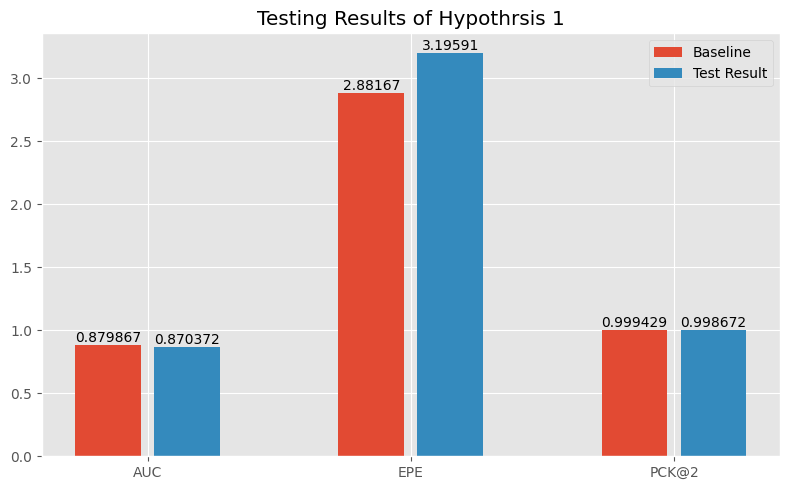

In [235]:
hyp1 = [[0.8798666666666666, 2.881668154761905, 0.9994285714285716], # baseline
        [0.8703719112787792, 3.1959057284804566, 0.9986720166858363]] # test res
# x ticks for plot
xtick = ['AUC', 'EPE', 'PCK@2']

plt.figure(figsize=(8,5))
bar0 = plt.bar(x = np.arange(3), height = hyp1[0], width = 0.25, label = 'Baseline', tick_label = xtick)
bar1 = plt.bar(x = np.arange(3)+0.3, height = hyp1[1], width = 0.25, label = 'Test Result')
plt.bar_label(bar0)
plt.bar_label(bar1)
plt.title('Testing Results of Hypothrsis 1') # title
plt.xticks(np.arange(3)+0.15, xtick) # x ticks
plt.legend() # show legend

plt.tight_layout()
plt.show()

- Differences between baseline and testing for Hypothrsis 1

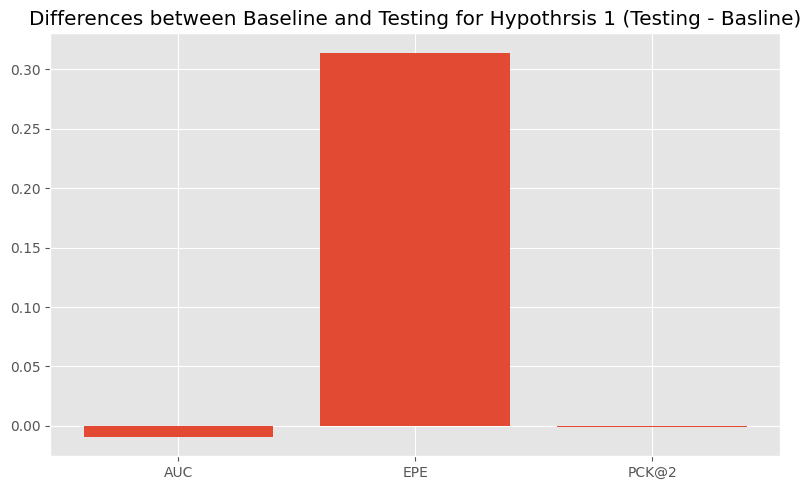

In [236]:
plt.figure(figsize=(8,5))
hyp1_diff = [hyp1[1][i]- hyp1[0][i] for i in range(len(hyp1[0]))]
plt.bar(xtick, hyp1_diff, tick_label = xtick)
plt.title('Differences between Baseline and Testing for Hypothrsis 1 (Testing - Basline)') # title

plt.tight_layout()
plt.show()

- AUC Testing Results of Hypothrsis 2

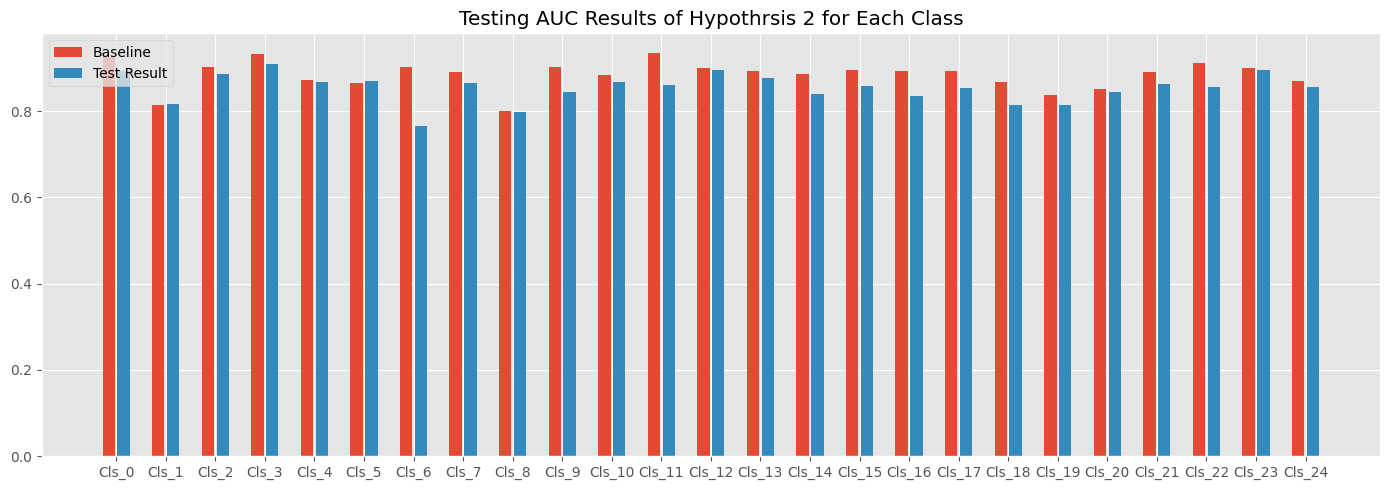

In [246]:
hyp2_auc = [
            [0.925714285714286, 0.8142857142857144, 0.9033333333333337, 0.9314285714285717, 0.8719047619047622,
             0.8661904761904765, 0.9033333333333337, 0.8914285714285717, 0.7995238095238097, 0.9033333333333337,
             0.8847619047619051, 0.9338095238095241, 0.8995238095238098, 0.8942857142857146, 0.885714285714286,
             0.8947619047619051, 0.893809523809524, 0.893809523809524, 0.868095238095238, 0.8366666666666667,
             0.8519047619047622, 0.8914285714285717, 0.9114285714285717, 0.8995238095238098, 0.8700000000000003], # baseline

            [0.8928571428571432, 0.8174149659863946, 0.885385487528345, 0.9085034013605445, 0.8683673469387758,
             0.8690476190476193, 0.7664399092970521, 0.8648526077097509, 0.7982993197278915, 0.8450680272108846,
             0.8679138321995469, 0.8609410430839003, 0.894557823129252, 0.8769727891156466, 0.8392743764172338,
             0.8581632653061222, 0.835578231292517, 0.8528004535147395, 0.8151587301587302, 0.8136167800453519,
             0.8453741496598639, 0.8624716553287985, 0.8557823129251703, 0.8962585034013608, 0.8562585034013609]] # test res

# x ticks for plot
xtick = ['Cls_'+str(i) for i in range(25)]

plt.figure(figsize=(14,5))
bar0 = plt.bar(x = np.arange(25), height = hyp2_auc[0], width = 0.25, label = 'Baseline', tick_label = xtick)
bar1 = plt.bar(x = np.arange(25)+0.3, height = hyp2_auc[1], width = 0.25, label = 'Test Result')
plt.title('Testing AUC Results of Hypothrsis 2 for Each Class') # title
plt.xticks(np.arange(25)+0.15, xtick) # x ticks
plt.legend() # show legend

plt.tight_layout()
plt.show()

- AUC Differences between baseline and testing for Hypothrsis 2

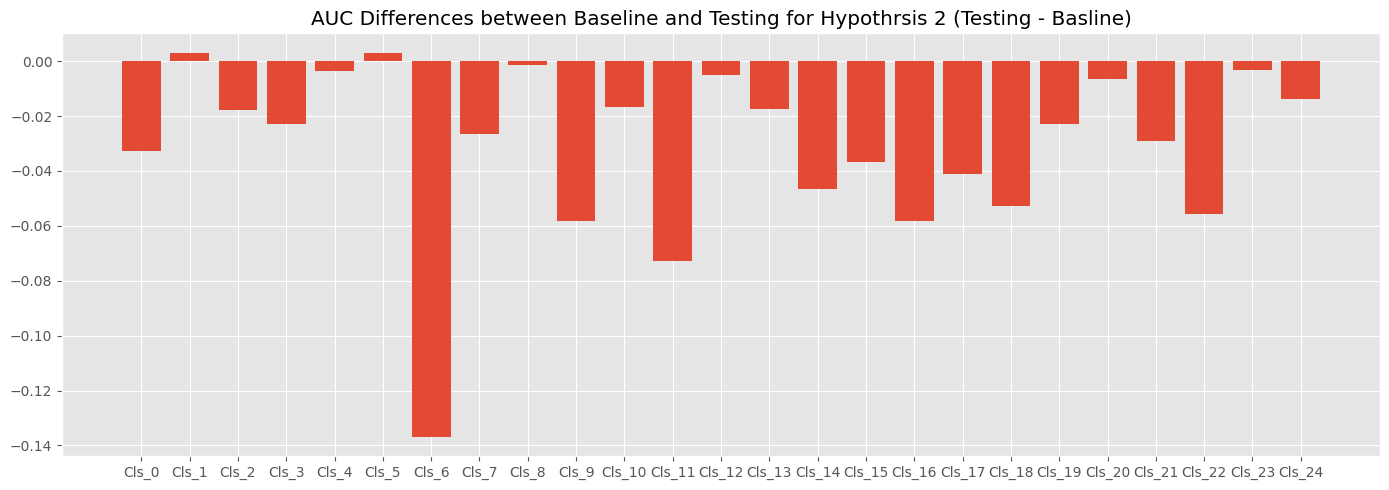

In [249]:
plt.figure(figsize=(14,5))
hyp2_auc_diff = [hyp2_auc[1][i]- hyp2_auc[0][i] for i in range(len(hyp2_auc[0]))]
plt.bar(xtick, hyp2_auc_diff, tick_label = xtick)
plt.title('AUC Differences between Baseline and Testing for Hypothrsis 2 (Testing - Basline)') # title

plt.tight_layout()
plt.show()

- EPE Testing Results of Hypothrsis 2

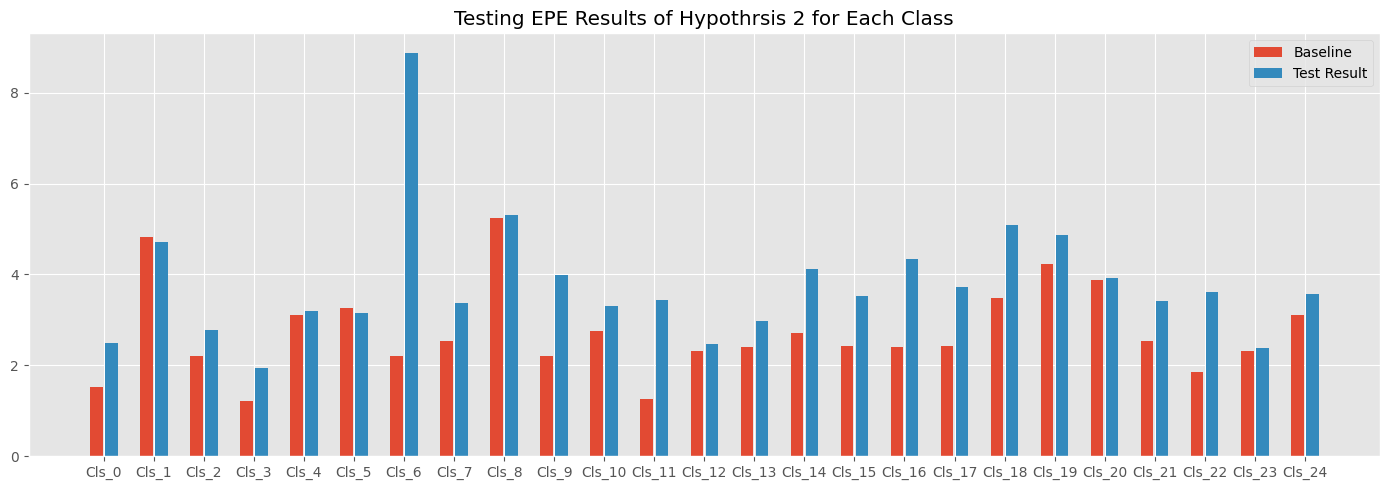

In [248]:
hyp2_epe = [
            [1.5279529389880953, 4.831201753162202, 2.194779023670015, 1.2103806268601192, 3.1050606863839287,
             3.255031040736607, 2.194779023670015, 2.5343296595982143, 5.2502197265625, 2.194779023670015,
             2.7517851329985117, 1.2654105050223214, 2.3178687686011905, 2.393192109607515, 2.7050667898995537,
             2.4139798118954614, 2.4108809698195683, 2.426870291573661, 3.4739888509114585, 4.224877639043899,
             3.8831859770275297, 2.531117175874256, 1.8594293503534227, 2.3178687686011905, 3.1102655319940475], # baseline

            [2.4842375670971513, 4.72332763671875, 2.76630068496919, 1.9321704267644557, 3.1993723759034864,
             3.1595566937712585, 8.862333668221673, 3.373360393716277, 5.302793749335672, 3.984975828346631,
             3.300580964265046, 3.445992290109828, 2.4666899596752763, 2.968260023328993, 4.129350259270467,
             3.5317295619419644, 4.338929503114073, 3.7125481255620505, 5.078706416377315, 4.872380913628472,
             3.925135770290018, 3.408055623372396, 3.6125129250919117, 2.3894464401971724, 3.557707157841435]] # test res

# x ticks for plot
xtick = ['Cls_'+str(i) for i in range(25)]

plt.figure(figsize=(14,5))
bar0 = plt.bar(x = np.arange(25), height = hyp2_epe[0], width = 0.25, label = 'Baseline', tick_label = xtick)
bar1 = plt.bar(x = np.arange(25)+0.3, height = hyp2_epe[1], width = 0.25, label = 'Test Result')
plt.title('Testing EPE Results of Hypothrsis 2 for Each Class') # title
plt.xticks(np.arange(25)+0.15, xtick) # x ticks
plt.legend() # show legend

plt.tight_layout()
plt.show()

- EPE Differences between baseline and testing for Hypothrsis 2

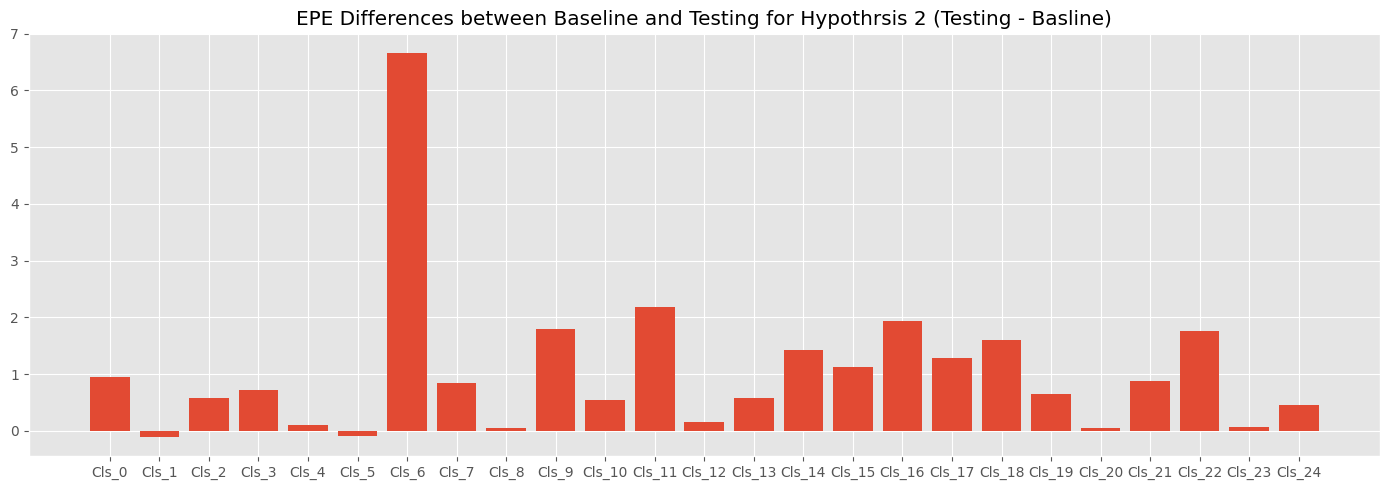

In [250]:
plt.figure(figsize=(14,5))
hyp2_epe_diff = [hyp2_epe[1][i]- hyp2_epe[0][i] for i in range(len(hyp2_epe[0]))]
plt.bar(xtick, hyp2_epe_diff, tick_label = xtick)
plt.title('EPE Differences between Baseline and Testing for Hypothrsis 2 (Testing - Basline)') # title

plt.tight_layout()
plt.show()

# 7.Inference on own_test imgs

- Function to Visualise Inferenced Image

In [261]:
# inference image
def inference_res(test_root_path, image_name):
    test_image = test_root_path + '/' + image_name
    config = 'mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py'
    model = 'mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth'

    pose_model = init_pose_model(config, model)
    dataset_info = DatasetInfo(pose_model.cfg.data['test'].get('dataset_info', None))
    person_result = None

    pose_results, _ = inference_top_down_pose_model(pose_model,
                                                    test_image,
                                                    person_result,
                                                    format='xywh',
                                                    dataset_info=dataset_info)

    estimated_res = vis_pose_result(pose_model,
                                    test_image,
                                    pose_results,
                                    dataset_info = dataset_info)
    return estimated_res, pose_results

- Visualise inference Results of own test set

In [265]:
infer_own_test = 'mmpose/data/freihand/training/own_resize_test' # own images path (original), this path will only contain own ori img file
infer_own_image_list = os.listdir(own_test) # list contains file name under img path
all_infer_own_img = []
for i in range(len(infer_own_image_list)):
    estimated_res, pose_results = inference_res(infer_own_test, infer_own_image_list[i])
    estimated_res = estimated_res[:, :, ::-1] # BGR -> RGB
    all_infer_own_img.append(estimated_res)

load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth
load checkpoint from local path: mmpose/model/res50_freihand_224x224-ff0799bc_20200914.pth

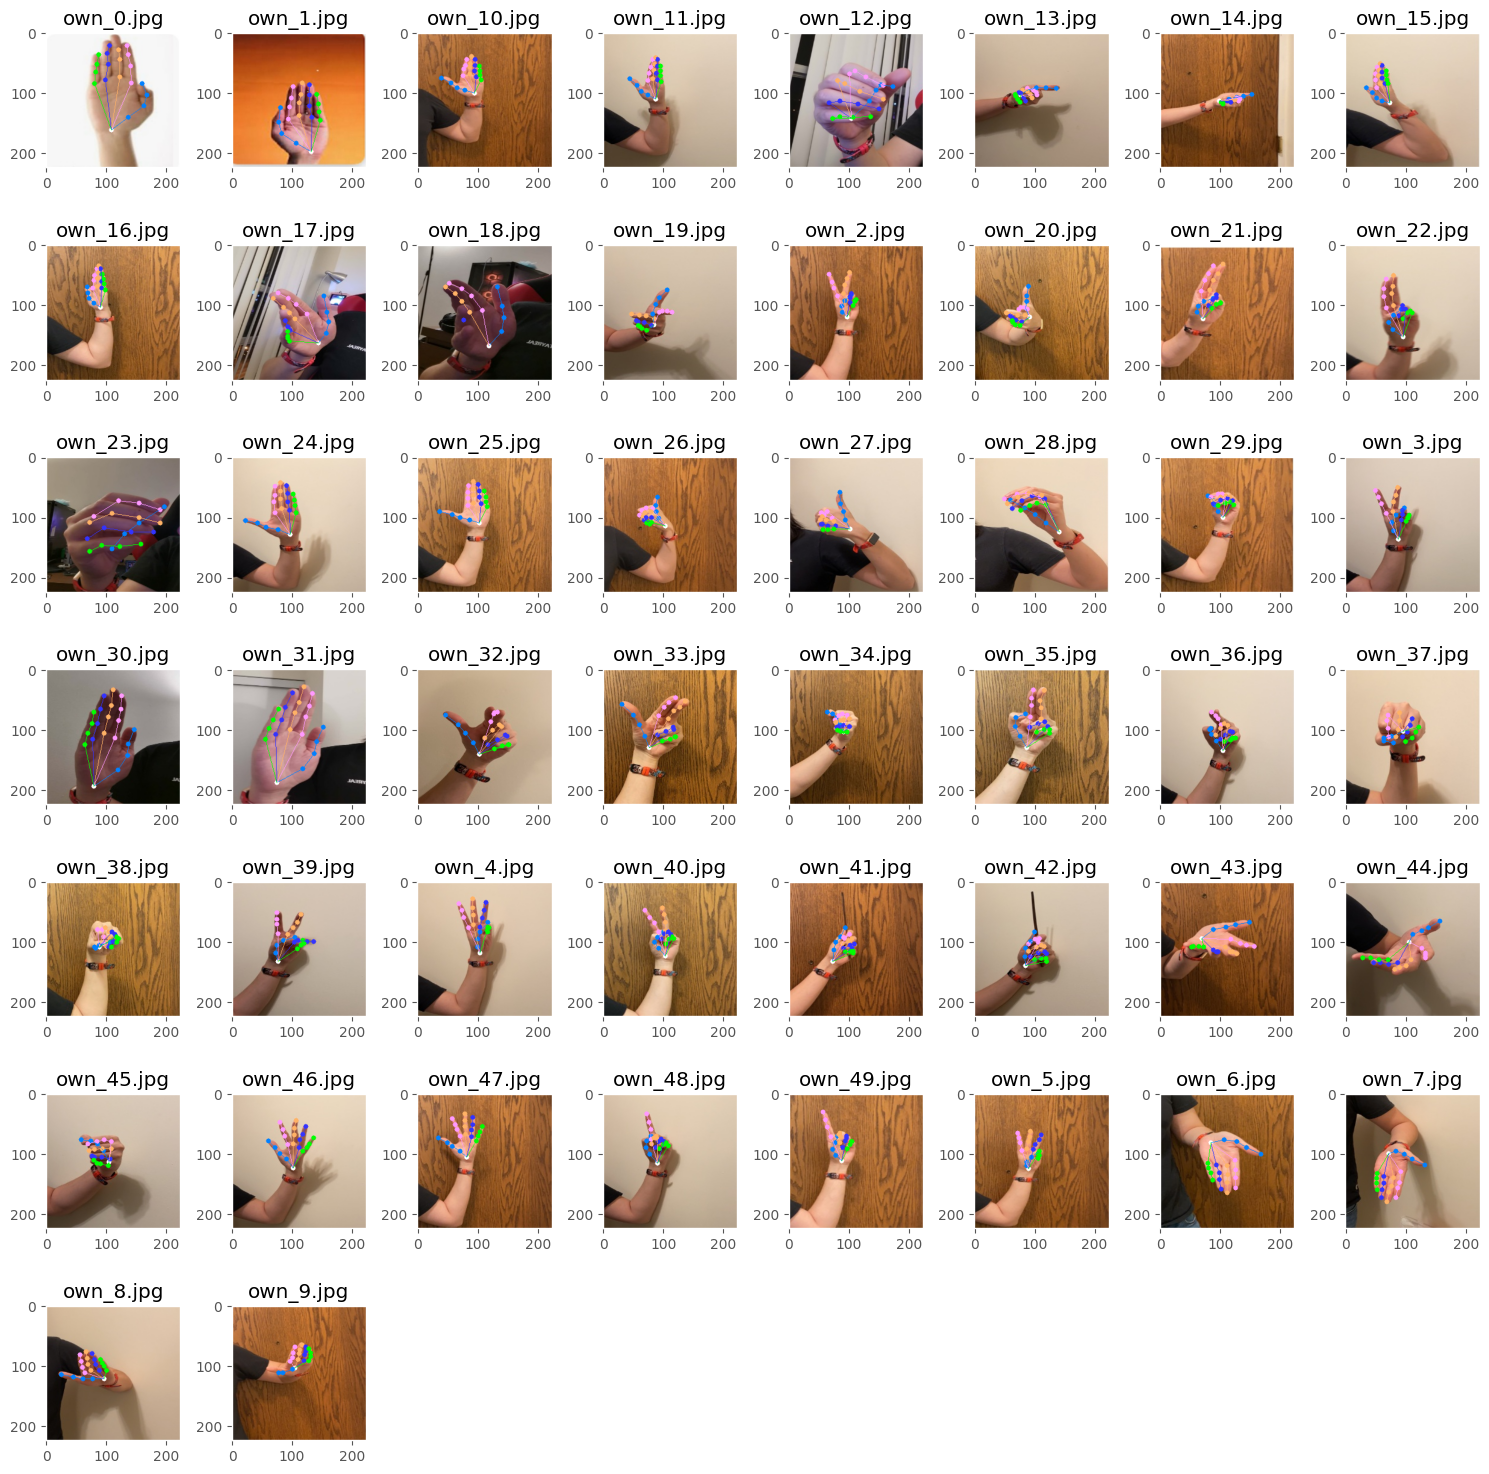

In [266]:
# plot original own_test img
plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(7, 8)
for i in range(len(infer_own_image_list)):
    ax = plt.subplot(gs[i])
    ax.set_title(infer_own_image_list[i])
    ax.grid(False)
    ax.imshow(all_infer_own_img[i])
plt.tight_layout()
plt.show()